# Refined Stratified Sampling Example 8
Author: Mohit S. Chauhan Date: Aug 20, 2018

In this example, Stratified sampling is used to generate samples from Uniform distribution and sample expnsion is done adaptively using Refined Stratified Sampling.

Import the necessary libraries. Here we import standard libraries such as numpy, matplotlib and other necessary library for plots, but also need to import the STS and  RSS from UQpy. 

In [1]:
from UQpy.SampleMethods import STS
from UQpy.SampleMethods import RSS
from UQpy.Surrogates import Krig
from UQpy.RunModel import RunModel
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits import mplot3d
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.patches as patches
import numpy as np

Using UQpy STS class to generate samples for two random variables, which are uniformly distributed between 0 and 1.

In [2]:
x = STS(dist_name=['Uniform', 'Uniform'], dist_params=[[0, 1], [0, 1]], sts_design=[4, 4])

UQpy: Successful execution of STS design..


This plot shows the samples and stratas generated by the STS class.

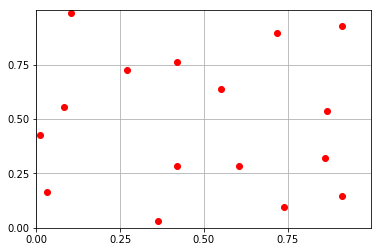

In [3]:
fig2 = plt.figure()
plt.plot(x.samples[:, 0], x.samples[:, 1], 'ro')
ax = fig2.gca()
ax.set_xticks(np.arange(0, 1, 0.25))
ax.set_yticks(np.arange(0, 1, 0.25))
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.grid()
plt.show()

RunModel class is used to estimate the function value at sample points generated using STS class.

In [4]:
y_val = RunModel(x.samples, model_script='python_model_function.py')

Scikit kriging generated a surrogate model using STS samples and function value at those points.

In [5]:
%%capture
corr_model = Matern(10*np.ones([x.dimension, 1]), [[1e-2, 1e5]]*x.dimension, nu=0.5)
gp = GaussianProcessRegressor(kernel=corr_model, n_restarts_optimizer=0)
gp.fit(x.samples, y_val.qoi_list)

TypeError: unsupported format string passed to numpy.ndarray.__format__

This figure shows the actual function defined in python model script.

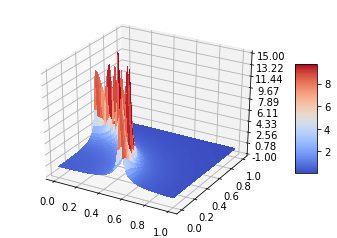

In [6]:
num = 50
x1 = np.linspace(0, 1, num)
x2 = np.linspace(0, 1, num)
x1v, x2v = np.meshgrid(x1, x2)
y_act = np.zeros([num, num])
for i in range(num):
    for j in range(num):
        y_act[i, j] = RunModel(np.array([[x1v[i, j], x2v[i, j]]]), model_script='python_model_function.py').qoi_list[0]
fig1 = plt.figure()
ax = fig1.gca(projection='3d')
# Plot for estimated values
surf = ax.plot_surface(x1v, x2v, y_act, cmap=cm.coolwarm, linewidth=0, antialiased=False)
# Customize the z axis.
ax.set_zlim(-1, 15)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
# Add a color bar which maps values to colors.
fig1.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

This figure shows the surrogate model generated using scikit kriging from initial samples.

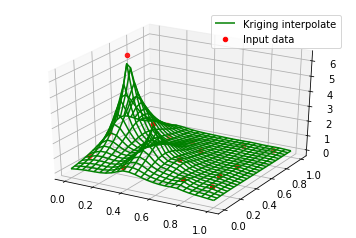

In [7]:
num = 25
x1 = np.linspace(0, 1, num)
x2 = np.linspace(0, 1, num)
x1v, x2v = np.meshgrid(x1, x2)
y = np.zeros([num, num])
for i in range(num):
    for j in range(num):
        y[i, j] = gp.predict(np.array([[x1v[i, j], x2v[i, j]]]))

fig = plt.figure()
ax = plt.axes(projection='3d')
# Plot for estimated values
kr = ax.plot_wireframe(x1v, x2v, y, color='Green', label='Kriging interpolate')

# Plot for scattered data
ID = ax.scatter3D(x.samples[:, 0], x.samples[:, 1], np.array(y_val.qoi_list), color='Red', label='Input data')
plt.legend(handles=[kr, ID])
plt.show()

Using UQpy RSS class to expand samples generated by STS class. In this example, meta specifies the method used to estimate the gradient. 

In [8]:
%%capture
z = RSS(x=x, model='python_model_function.py', meta='Kriging_Sklearn', nsamples=200, cell='Voronoi',
        min_train_size=200, corr_model=corr_model);

This figure shows the new samples generated using RSS class.

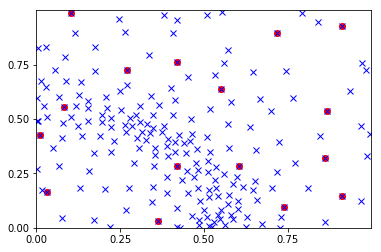

In [9]:
fig = plt.figure()
ax = fig.gca()
ax.set_xticks(np.arange(0, 1, 0.25))
ax.set_yticks(np.arange(0, 1, 0.25))
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.plot(x.samples[:, 0], x.samples[:, 1], 'ro')
plt.plot(z.samplesU01[:, 0], z.samplesU01[:, 1], 'bx')
plt.show()

Scikit kriging is used to generate a surrogate model using final samples from RSS class.

In [10]:
gp2 = GaussianProcessRegressor(kernel=corr_model, n_restarts_optimizer=0)
gp2.fit(z.samples, z.values)

/usr/local/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


TypeError: unsupported format string passed to numpy.ndarray.__format__

This figure shows the final surrogate model, generated using 200 samples.

/usr/local/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


<Figure size 432x288 with 0 Axes>

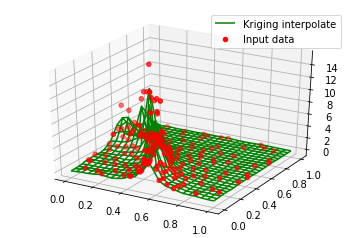

In [11]:
y = np.zeros([num, num])
for i in range(num):
    for j in range(num):
        y[i, j] = y[i, j] = gp2.predict(np.array([[x1v[i, j], x2v[i, j]]]))

plt.clf()
fig4 = plt.figure()
a2 = fig4.gca()
a2 = plt.axes(projection='3d')
# Plot for estimated values
kr = a2.plot_wireframe(x1v, x2v, y, color='Green', label='Kriging interpolate')

# Plot for scattered data
ID = a2.scatter3D(z.samples[:, 0], z.samples[:, 1], z.values, color='Red', label='Input data')
plt.legend(handles=[kr, ID])
plt.show()